# Tutorial: Clean Data with Functional Dependencies

In this notebook, you'll learn to use functional dependencies for data cleaning. A functional dependency exists when one column in a dataset is a function of another column. For example, the Zip Code might determine the City. A functional dependency manifests itself as a one-to-many relationship between the values in two (or more) columns within a DataFrame (which does not occur if the dataset adheres to 3rd normal form). This tutorial uses the SYNTHEA dataset to show how functional relationships can be instrumental in the automatic detection of data quality problems.


### In this tutorial, you learn how to:
- Apply domain knowledge to formulate hypotheses about functional dependencies in a dataset;
- Get familiarized with components of Semantic Link's Python library ([SemPy](https://learn.microsoft.com/en-us/python/api/semantic-link-sempy)) that helps to automate data quality analysis. These components include:
    - FabricDataFrame - a pandas-like structure enhanced with additional semantic information;
    - Useful functions that automate the evaluation of hypothesis about functional dependencies and that identify violations of relationships in your datasets.

### Prerequisites
1.    A Premium Power BI subscription.   
2.    A Power BI Workspace with assigned premium capacity.
3.    An existing lakehouse attached to the workspace.

* A [Microsoft Fabric subscription](https://learn.microsoft.com/fabric/enterprise/licenses). Or sign up for a free [Microsoft Fabric (Preview) trial](https://learn.microsoft.com/fabric/get-started/fabric-trial).
* Sign in to [Microsoft Fabric](https://fabric.microsoft.com/).
* Go to the Data Science experience in Microsoft Fabric.
* Create [a new notebook](https://learn.microsoft.com/fabric/data-engineering/how-to-use-notebook#create-notebooks) to copy/paste code into cells.

## Set up the notebook

In this section, you'll set up a notebook environment with the necessary modules and data.

First, install `SemPy` from PyPI using pip magic command:

In [2]:
%pip install semantic-link

StatementMeta(, 9afa62c0-2f41-4e2f-beee-d9693947e160, -1, Finished, Available)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 15.9 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 kB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 144.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 754.3/754.3 kB 142.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 156.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 76.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 92.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 99.3 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 174.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: /nfs4/pyenv-154c9fb6-48a9-4646-a02c-29344d3c978e/bin/python -m pip install --upgrade

Then, perform necessary imports of modules that you'll need later on:

In [3]:
import pandas as pd
import sempy.fabric as fabric
from sempy.fabric import FabricDataFrame
from sempy.dependencies import plot_dependency_metadata
from sempy.samples import download_synthea

StatementMeta(, 9afa62c0-2f41-4e2f-beee-d9693947e160, 12, Finished, Available)

Lastly, pull the sample data - for this tutorial, you'll use the SYNTHEA dataset of synthetic medical records (small version for simplicity):

In [4]:
download_synthea(which='small')

StatementMeta(, 9afa62c0-2f41-4e2f-beee-d9693947e160, 13, Finished, Available)

'abfss://1895b289-58e6-4ccb-8548-b5ef3dc312b3@msit-onelake.dfs.fabric.microsoft.com/11631641-5456-4f90-90b3-431e0cf03650/Files/synthea/csv'

## Explore data

Initialize a ``FabricDataFrame`` with the dataframe corresponding to 'providers':

In [5]:
providers = FabricDataFrame(pd.read_csv("synthea/csv/providers.csv"))
providers.head()

StatementMeta(, 9afa62c0-2f41-4e2f-beee-d9693947e160, 14, Finished, Available)

,Id,ORGANIZATION,NAME,GENDER,SPECIALITY,ADDRESS,CITY,STATE,ZIP,LAT,LON,UTILIZATION
0,3421aa75-dec7-378d-a9e0-0bc764e4cb0d,ef58ea08-d883-3957-8300-150554edc8fb,Tomas436 Sauer652,M,GENERAL PRACTICE,60 HOSPITAL ROAD,LEOMINSTER,MA,01453,42.520838,-71.770876,1557
1,c9b3c857-2e24-320c-a79a-87b8a60de63c,69176529-fd1f-3b3f-abce-a0a3626769eb,Suzette512 Monahan736,F,GENERAL PRACTICE,330 MOUNT AUBURN STREET,CAMBRIDGE,MA,02138,42.375967,-71.118275,2296
2,0359f968-d1a6-30eb-b1cc-e6cc0b4d3513,5e765f2b-e908-3888-9fc7-df2cb87beb58,Gaynell126 Streich926,F,GENERAL PRACTICE,211 PARK STREET,ATTLEBORO,MA,02703,41.931653,-71.294503,2287
3,446d1609-858f-3a54-8a52-0c4eacedd00e,f1fbcbfb-fcfa-3bd2-b7f4-df20f1b3c3a4,Patricia625 Salgado989,F,GENERAL PRACTICE,ONE GENERAL STREET,LAWRENCE,MA,01842,42.700273,-71.161357,1327
4,e6283e46-fd81-3611-9459-0edb1c3da357,e002090d-4e92-300e-b41e-7d1f21dee4c6,Jeanmarie510 Beatty507,F,GENERAL PRACTICE,1493 CAMBRIDGE STREET,CAMBRIDGE,MA,02138,42.375967,-71.118275,3199


To check for data quality issues with SemPy's ``find_dependencies`` function, plot a graph of auto-detected functional dependencies:

StatementMeta(, 9afa62c0-2f41-4e2f-beee-d9693947e160, 15, Finished, Available)

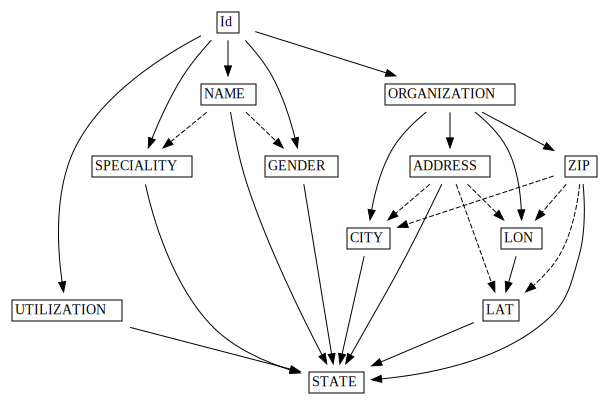

In [6]:
deps = providers.find_dependencies()
plot_dependency_metadata(deps)

The graph of functional dependencies shows that **Id** determines **NAME** and  **ORGANIZATION** (indicated by the solid arrows), which makes sense, since **Id** is unique:

In [7]:
providers.Id.is_unique

StatementMeta(, 9afa62c0-2f41-4e2f-beee-d9693947e160, 16, Finished, Available)

True

## Analyze functional dependencies in depth

The functional dependencies graph also shows that **ORGANIZATION** determines **ADDRESS** and **ZIP**, as expected. However, you might expect **ZIP** to also determine **CITY**, but the dashed arrow indicates that the dependency is only approximate, pointing towards a data quality issue.

There are other peculiarities in the graph. For example, **NAME** does not determine **GENDER**, **Id**, **SPECIALITY** or **ORGANIZATION**. Each of these might be worth investigating.

Take an in-depth look at the approximate relationship between **ZIP** and **CITY** by using SemPy's ``list_dependency_violations`` function to see a tabular list of violations:

In [8]:
providers.list_dependency_violations('ZIP', 'CITY')

StatementMeta(, 9afa62c0-2f41-4e2f-beee-d9693947e160, 17, Finished, Available)

,ZIP,CITY,count
0,02135-3514,BOSTON,53
1,02135-3514,BRIGHTON,2
2,02747-1262,DARTMOUTH,9
3,02747-1262,NORTH DARTMOUTH,1
4,01950,NEWBURGPORT,3
5,01950,NEWBURYPORT,1
6,02114,BOSTON,3
7,02114,Boston,1
8,02190-2314,SOUTH WEYMOUTH,3
9,02190-2314,WEYMOUTH,1


If the number of violations is small, it may be helpful to draw a graph with SemPy's visualization function called ``plot_dependency_violations``:

StatementMeta(, 9afa62c0-2f41-4e2f-beee-d9693947e160, 18, Finished, Available)

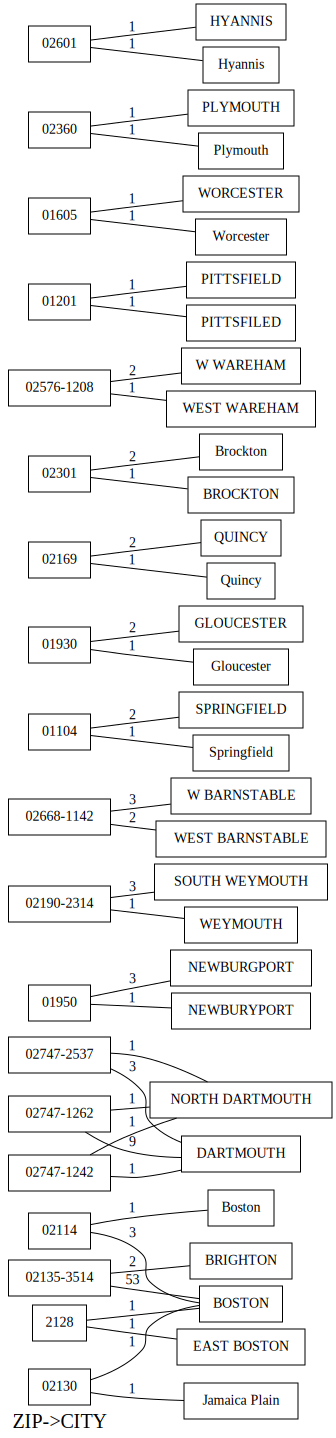

In [9]:
providers.plot_dependency_violations('ZIP', 'CITY')

The plot of dependency violations shows values for **ZIP** on the left hand side, and values for **CITY** on the right hand side. An edge connects a **ZIP** on the left with a **CITY** on the right if there is a row that contains these two respective values. The edges are annotated with the count of such rows. For example, there are two rows with ZIP code 02747-1242, one with CITY "NORTH DARTHMOUTH" and one with CITY "DARTHMOUTH":

In [10]:
providers[providers.ZIP == '02747-1242'].CITY.value_counts()

StatementMeta(, 9afa62c0-2f41-4e2f-beee-d9693947e160, 19, Finished, Available)

NORTH DARTMOUTH    1
DARTMOUTH          1
Name: CITY, dtype: int64

The plot also shows that among the rows that have CITY as "DARTHMOUTH", nine rows have a ZIP of 02747-1262, one row has a ZIP of 02747-1242 and one row has a ZIP of 02747-2537:

In [ ]:
providers[providers.CITY == 'DARTMOUTH'].ZIP.value_counts()

There are other ZIP codes associated with "DARTMOUTH", but these aren't shown in the graph of dependency violations, as they don't hint at data quality issues. An example is "02747-4302" that is uniquely associated to "DARTMOUTH":

In [ ]:
providers[providers.ZIP == '02747-4302'].CITY.value_counts()

## Summarize data quality issues detected with SemPy

Going back to the graph of dependency violations, you can see that there are actually several interesting data quality issues present in this dataset:

- Some city names are all-caps. This is an easy to fix using string methods.
- Some city names have qualifiers, with "2128" mapping to "EAST BOSTON" once and to "BOSTON" once. A similar issue happens between "NORTH DARTHMOUTH" and "DARTHMOUTH". You could try to drop these qualifiers or map to the most common occurrence.
- There are typos in some cities, such as "PITTSFIELD" vs "PITTSFILED" and "NEWBURGPORT vs "NEWBURYPORT". In the case of "NEWBURGPORT" this typo could be fixed by using the most common occurrence. In the case of "PITTSFIELD", having only one occurrence each makes it much harder for automatic disambiguation without external knowledge or a language model.
- Sometimes, prefixes like "West" are abbreviated to a single letter "W". This could potentially be fixed with a simple replace, if all occurrences of "W" stand for "West".
- "02130" maps to "BOSTON" once and "Jamaica Plain" once. This issue is not easy to fix, but if there was more data, mapping to the most common occurrence might be useful.

## Clean data

Fix the capitalization issues by changing all capitalization to "title":

In [11]:
providers['CITY'] = providers.CITY.str.title()

StatementMeta(, 9afa62c0-2f41-4e2f-beee-d9693947e160, 20, Finished, Available)

Now, running the violation detection again to see that some of the ambiguities have been removed (the number of violations is smaller):

In [12]:
providers.list_dependency_violations('ZIP', 'CITY')

StatementMeta(, 9afa62c0-2f41-4e2f-beee-d9693947e160, 21, Finished, Available)

,ZIP,CITY,count
0,02135-3514,Boston,53
1,02135-3514,Brighton,2
2,02747-1262,Dartmouth,9
3,02747-1262,North Dartmouth,1
4,01950,Newburgport,3
5,01950,Newburyport,1
6,02190-2314,South Weymouth,3
7,02190-2314,Weymouth,1
8,02668-1142,W Barnstable,3
9,02668-1142,West Barnstable,2


At this point, you could refine your data more manually, but one potential data cleanup task is to drop rows that violate functional constraints between columns in the data, by using SemPy's ``drop_dependency_violations`` function. For each value of the determinant, this function works by picking the most common value of the dependent and dropping all rows with other values. You should apply this operation only if you're confident that this statistical heuristic would lead to the correct results for your data. Otherwise you should write your own code to handle the detected violations as needed.

In [13]:
providers_clean = providers.drop_dependency_violations('ZIP', 'CITY')
providers_clean.list_dependency_violations('ZIP', 'CITY')

StatementMeta(, 9afa62c0-2f41-4e2f-beee-d9693947e160, 22, Finished, Available)

No violations


,ZIP,CITY,count


After this operation, there are no more violations of the functional constraint **CITY -> ZIP**, as shown with the help of the ``list_dependency_violations`` function.

## Next step

Try using the learned ways of detecting data quality issues on your data and get amazed with the discoveries!

## Related content

Check out other tutorials for Semantic Link / SemPy:
1. Analyze Functional Dependencies in a PowerBI Sample Dataset
1. Detect Relationships in SYNTHEA dataset
1. Detect Relationships in a PowerBI Sample Dataset
1. Extract and Calculate PowerBI Measures from Jupyter Notebook